In [4]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

## Toy model

Input X - corresponds to any kind of phase space input - some **distribution** with prior.
Input $\mu$ - corresponds to parameters of surrogate, ie - size of detector, magnetic field, etc. - a **number**.

Define some functions f, g - those can be varied. Probably, bettern to stick with some types of them, ie:
continous, pereodic, polynomial, ...


$$X \sim U(x_{min}, x_{max}), \ \ \mu \sim \delta(\mu - \mu_0) $$

$$latent\_x \sim  \mathcal{N} (latent\_x | X, 1)$$


$$ f(\alpha) = a + b \alpha  $$
$$ g(\alpha) = d * \alpha $$

$$y \sim \mathcal{N}(y|f(latent\_x) + g(\mu), 1)$$

### Problem statement

1. Fit GAN/GP/NV to match p(y|X,mu)

2. Solve optimisaiton problem of the choise:
 - $argmin_{mu} (y - Y_0) ^2 $
 - $argmax_{mu} p(y|mu) = \int p(y|X,mu) p(X) dx$
 - $etc$



## Make model with `pyro`


## Investigation of the model

In [5]:
y_sampler = YModel(init_mu=torch.tensor([0.] * 2))

In [6]:
mu_dim = 2
x_dim = 1
mu_range = (-10, 10)
n_samples = 10000
noise_size = 1000

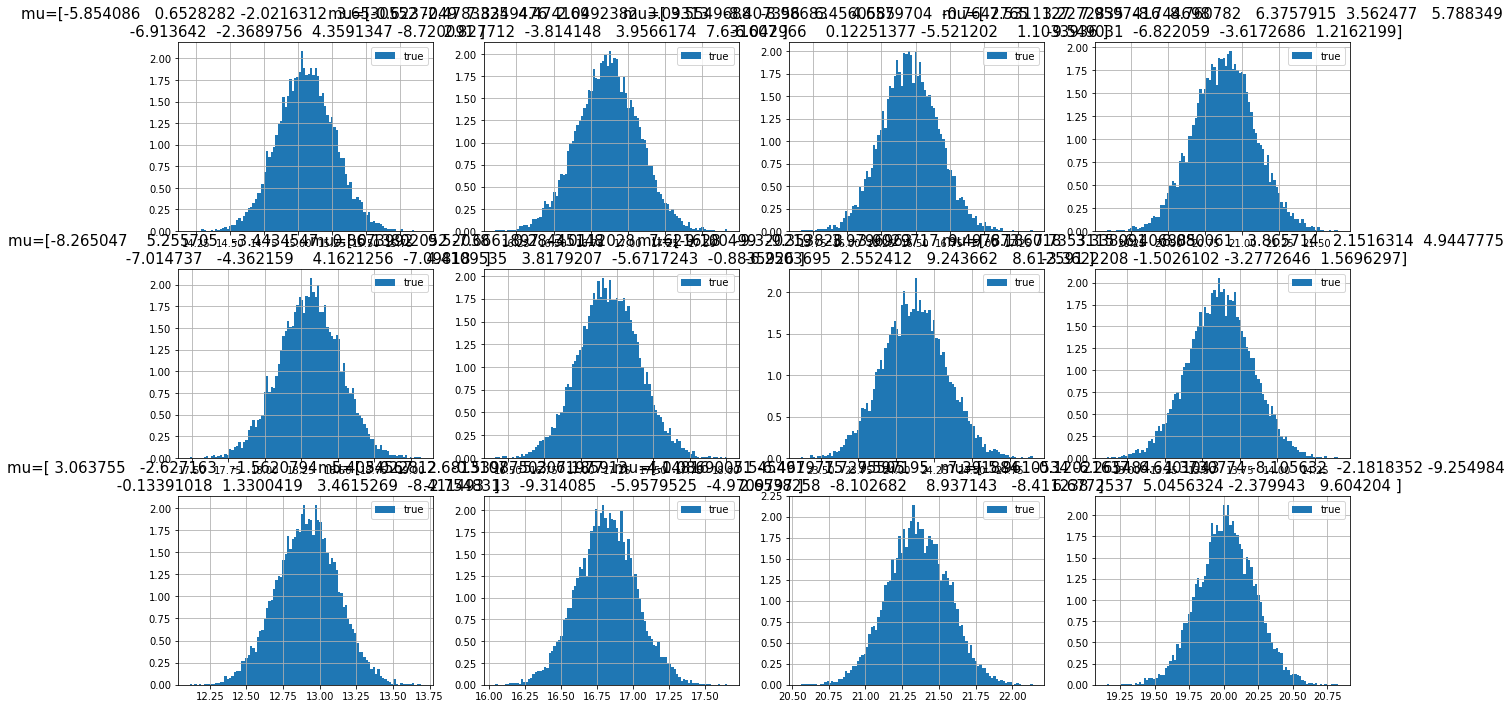

In [4]:
plt.figure(figsize=(21,16))
mu = dist.Uniform(*mu_range).sample([12, mu_dim])
for index in range(12):
    plt.subplot(4, 4, index + 1)

    mu_s = mu[index, :].repeat(n_samples, 1)
    x_s = y_sampler.x_dist.sample([len(mu_s), noise_size])
    y_sampler.make_condition_sample({'mu': mu_s, 'X':x_s})

    plt.hist(y_sampler.condition_sample().mean(dim=1).cpu().numpy(), bins=100, density=True, label='true');
    plt.grid()
    plt.legend()
    plt.title("mu={}".format(mu[index, :].cpu().numpy()), fontsize=15);

CPU times: user 836 ms, sys: 20 ms, total: 856 ms
Wall time: 858 ms


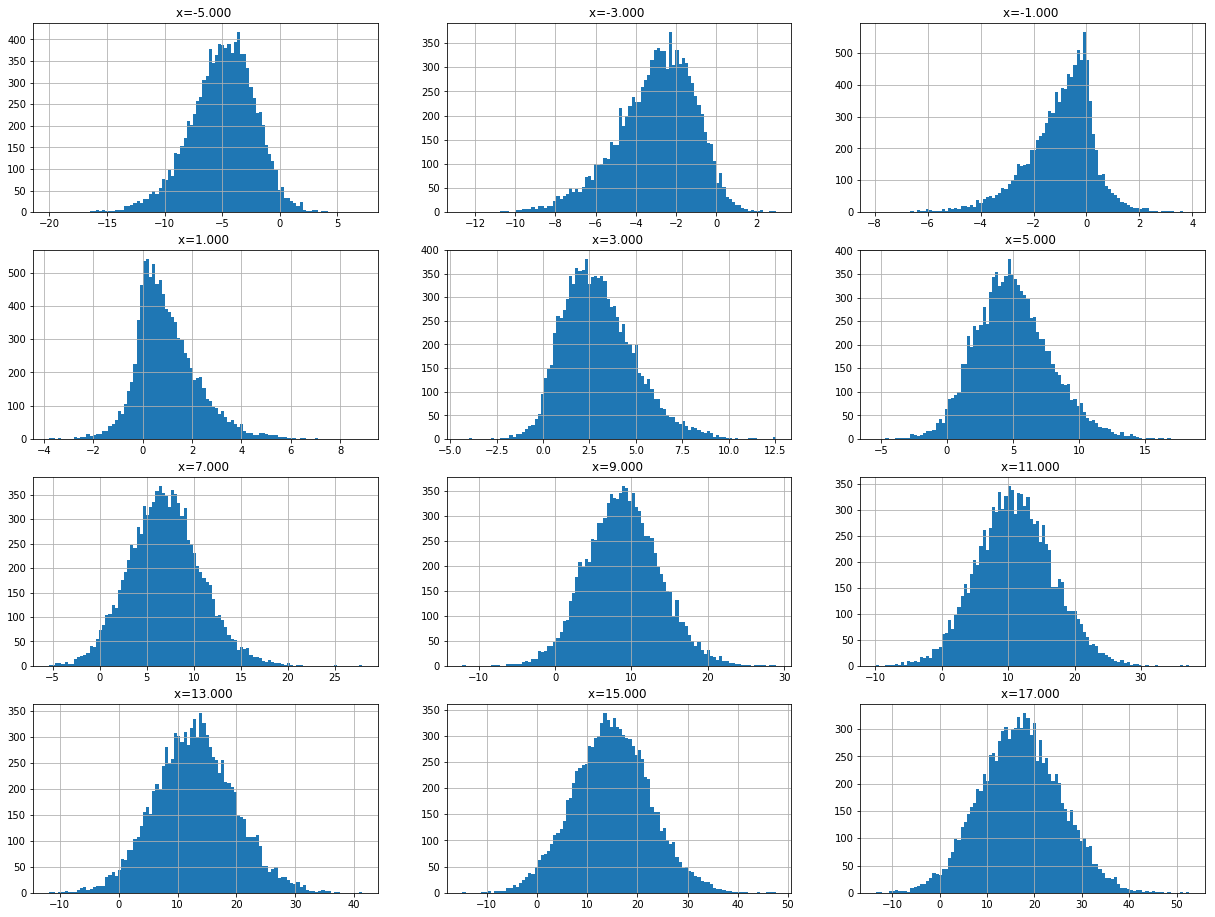

In [5]:
%%time
plt.figure(figsize=(21,16))
x_r = list(range(-5, 18, 2))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        y_sampler.make_condition_sample({'X': torch.tensor([float(x_r[i*3 + j])] * 10000).reshape(-1,1)})
        plt.hist(y_sampler.condition_sample().detach().numpy(), bins=100);
        plt.grid()
        #plt.legend()
        plt.title("x={:.3f} ".format(x_r[i*3 + j]))

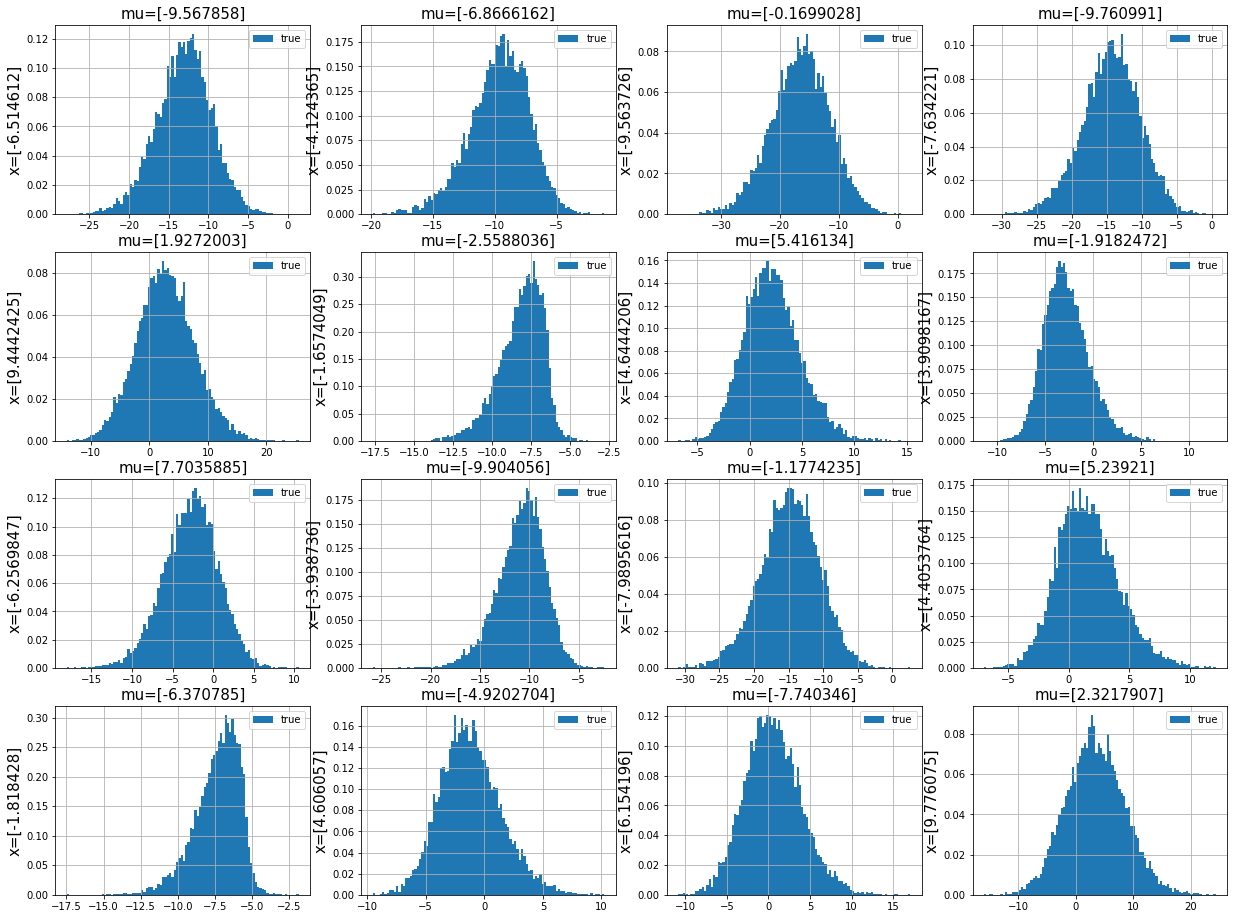

In [21]:
plt.figure(figsize=(21,16))

mu = dist.Uniform(*mu_range).sample([16, mu_dim])
x = y_sampler.x_dist.sample([16, x_dim])

for index in range(16):
    plt.subplot(4, 4, index + 1)
    mu_s = mu[index, :].repeat(10000, 1)
    x_s = x[index, :].repeat(10000, 1)
    y_sampler.make_condition_sample({'mu': mu_s, 'X':x_s})
    data = y_sampler.condition_sample().detach().cpu().numpy()

    plt.hist(data, bins=100, density=True, label='true');
    plt.grid()
    plt.legend()
    plt.ylabel("x={}".format(x[index, :].cpu().numpy()), fontsize=15)
    plt.title("mu={}".format(mu[index, :].cpu().numpy()), fontsize=15) 

In [8]:
my_cmap = plt.cm.jet
my_cmap.set_under('white')

# mu_r = torch.arange(-100, 100, 1, dtype=torch.double)
# x_r = y_sampler.x_dist.sample(torch.Size([1000, len(mu_r)])).double()

# y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})
# y = y_sampler.condition_sample()


# plt.figure(figsize=(12,6))

# mask = torch.abs(mu_r) < 10
# plt.pcolormesh(mu_r[mask], x_r[:, mask], y[:, mask], cmap=my_cmap);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

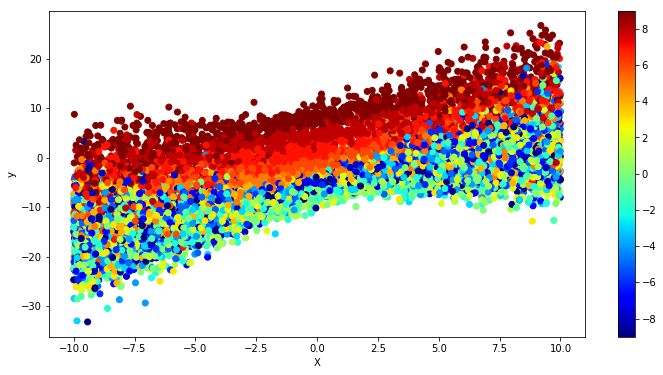

In [13]:
mask = torch.abs(mu_r) < 10
plt.figure(figsize=(12,6))
plt.scatter(x_r[:, mask], y[:, mask],
            c=mu_r[mask].reshape(-1,1).repeat(1, x_r.shape[0]).transpose(1,0), cmap=my_cmap)
plt.colorbar()
plt.xlabel("X");
plt.ylabel("y");

In [12]:
# plt.figure(figsize=(12,6))
# plt.pcolormesh(mu_r, x_r, y, cmap=my_cmap);
# plt.colorbar()
# plt.xlabel(r'$\mu$');
# plt.ylabel("X");

### 2d case for mu

In [7]:
import numpy as np
from itertools import product
from model import OptLoss

In [8]:
#mu = dist.Uniform(-10,10).sample([10000, 2])
x = np.linspace(-10, 10, 1000)
y = np.linspace(-10, 10, 1000)
mu = torch.tensor(np.array(list(product(x,y)))).float()

x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})



y_mean = y_sampler.condition_sample().mean(dim=1)

# plt.figure(figsize=(12,6))
# plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
# plt.colorbar()

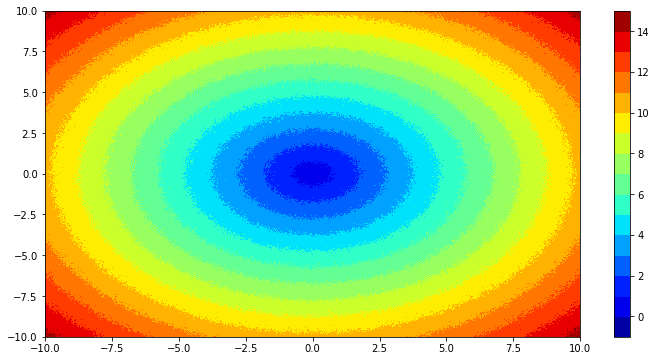

In [9]:
plt.figure(figsize=(12,6))
#plt.scatter(mu[:,0], mu[:, 1], c=y_mean, cmap=my_cmap)
plt.contourf(*np.meshgrid(x,y), y_mean.reshape(-1, 1000), cmap=my_cmap, levels=15)
plt.colorbar()

In [56]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, 5)

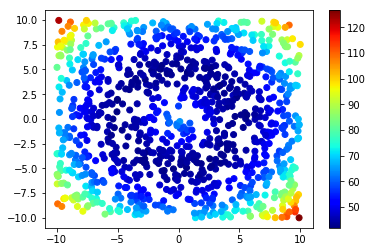

In [57]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

In [14]:
import numpy as np
mu = dist.Uniform(-10,10).sample([1000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))#.double()
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

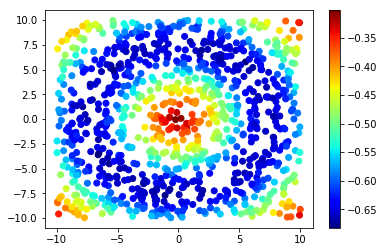

In [15]:
plt.scatter(mu[:,0], mu[:,1], c=rs,  cmap=my_cmap)
#plt.yscale("log")
plt.colorbar()

## Statistic of interest

$$r = \frac{1}{N} \sum\limits_{i=0}^{N} || y_i - Y ||_2^2$$

In [6]:
from model import OptLoss

## Approaches to solve the problem

### First one

  1. Make approximation of this model:

  $$p(y | \mu)$$

  With GANs or some other techniques.
  

  2. Sample $\{ y_i \}_{i=0}^{B} \sim p(y | \mu)$
  
  
  3. Calc $r = R(\{ y_i \}_{i=0}^{B})$
  
  
  4. Find $\frac{\partial r}{\partial \mu}$
  
### Second one


  1. Make approximation of this model:

  $$p(r | \mu)$$
  
  
  2. Sample $r \sim p(r | \mu)$
  
  
  3. Find $\frac{\partial r}{\partial \mu}$

In [7]:
import numpy as np
mu = torch.arange(-10,10,0.5).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.R(samples, -5)

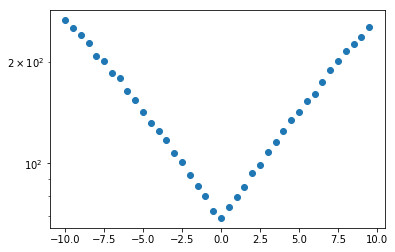

In [8]:
plt.scatter(mu, rs)
plt.yscale("log")

### Sigmoid loss

Text(0.5, 1.0, 'loss')

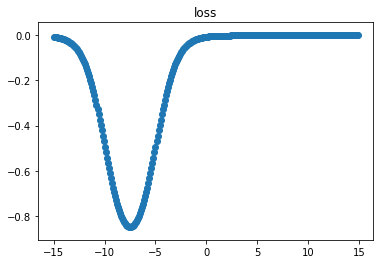

In [56]:
plt.scatter(np.arange(-15, 15, 0.1), OptLoss.SigmoidLoss(torch.tensor(np.arange(-15, 15, 0.1)).reshape(-1,1), -10, -5))
plt.title("loss")

In [71]:
import numpy as np
mu = torch.linspace(-30, 30, 1000).reshape(-1,1).float()
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 10000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

Text(0.5, 1.0, 'Average over X loss value')

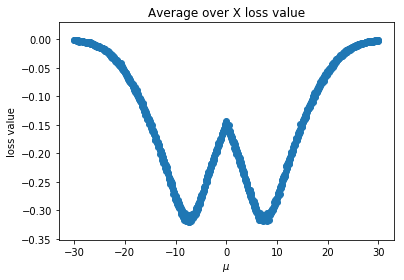

In [72]:
plt.scatter(mu, rs)
plt.xlabel("$\mu$")
plt.ylabel("loss value")
plt.title("Average over X loss value")
#plt.yscale("log")
#plt.xlim(-8,-2)

In [184]:
mu[np.argmin(rs)], torch.min(rs)

(tensor([-6.1812]), tensor(-0.4076))

## tests

In [59]:
from utils import generate_data

In [63]:
device = torch.device("cuda", 0)
d, i = generate_data(y_sampler, device, 100, mu_dim=2)
i.shape

torch.Size([100, 3])

In [65]:
from utils import DistPlotter, sample_noise
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=2):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

# Optimisation with true model

In [9]:
from model import YModel

In [10]:
y_sampler = YModel(init_mu=torch.tensor([0.]))


In [11]:
import numpy as np

In [18]:
mu_for_grad = torch.tensor([-1.]).reshape(1,-1)
mu_for_grad = mu_for_grad.repeat(1000, 1)
mu_for_grad.requires_grad=True

In [19]:
%%time
n_iter = 30000
losses = []
m_vals = []
lr = 10.
for _iter in range(n_iter):
    X = y_sampler.x_dist.sample([1000,1])    
    y_sampler.make_condition_sample({"mu": mu_for_grad, "X":X})
    samples = y_sampler.condition_sample()
    loss = OptLoss.SigmoidLoss(samples, -5, 5).mean()
    losses.append(loss.item())
    loss.backward()
    with torch.no_grad():
        mu_for_grad -= lr * mu_for_grad.grad.mean(dim=0, keepdim=True)
        mu_for_grad.grad.zero_()
    m_vals.append(mu_for_grad[0,0].item())
m_vals = np.array(m_vals)    

CPU times: user 2min 53s, sys: 7min 45s, total: 10min 38s
Wall time: 1min 6s


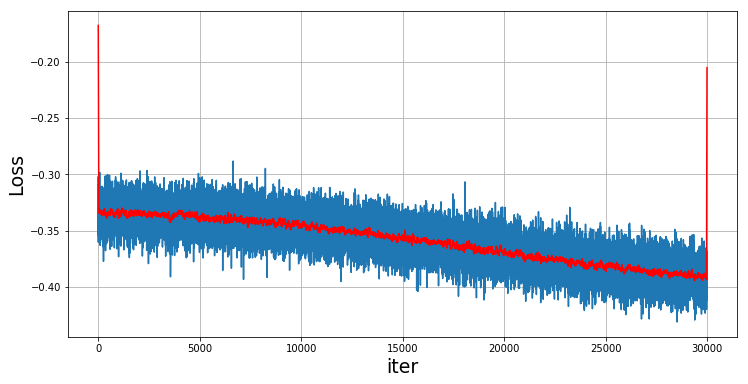

In [20]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')    


plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()
plt.ylabel("Loss", fontsize=19)
plt.xlabel("iter", fontsize=19)
plt.plot((movingaverage(losses, 50)), c='r')

Text(0.5, 0, 'iter')

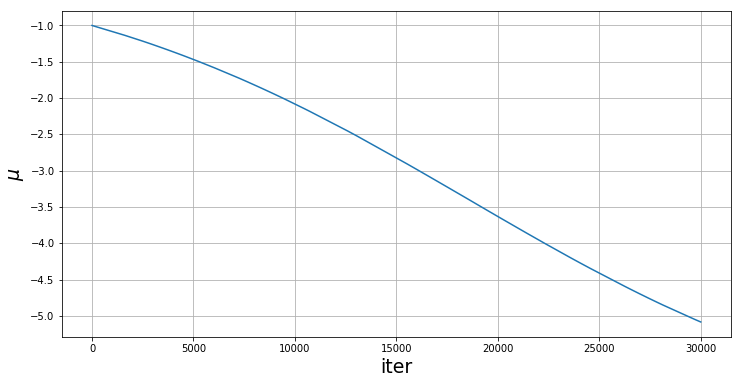

In [21]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()
plt.ylabel("$\mu$", fontsize=19)
plt.xlabel("iter", fontsize=19)

In [23]:
def find_mu(init_mu, n_iter=100000):
    mu_for_grad = torch.tensor([float(init_mu)]).reshape(1,-1)
    mu_for_grad = mu_for_grad.repeat(1000, 1)
    mu_for_grad.requires_grad=True    
#     losses = []
#     m_vals = []
    lr = 10.
    for _iter in range(n_iter):
        X = y_sampler.x_dist.sample([1000,1])    
        y_sampler.make_condition_sample({"mu": mu_for_grad, "X":X})
        samples = y_sampler.condition_sample()
        loss = OptLoss.SigmoidLoss(samples, -5, 5).mean()
        #losses.append(loss.item())
        loss.backward()
        with torch.no_grad():
            mu_for_grad -= lr * mu_for_grad.grad.mean(dim=0, keepdim=True)
            mu_for_grad.grad.zero_()
        #m_vals.append(mu_for_grad[0,0].item())
    #m_vals = np.array(m_vals)
    return mu_for_grad[0].item()

In [24]:
opt_mu = []
for mu in np.arange(-15, 16, 1):
    opt_mu.append(find_mu(mu))

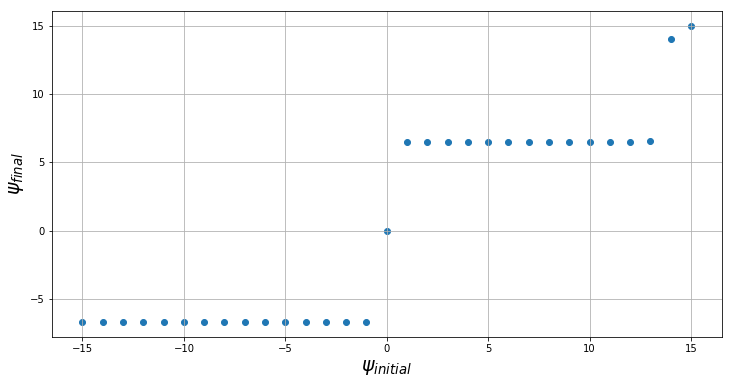

In [27]:
plt.figure(figsize=(12,6))
plt.scatter(np.arange(-15,16,1), opt_mu)
plt.grid()
plt.ylabel("$\psi_{final}$", fontsize=19)
plt.xlabel("$\psi_{initial}$", fontsize=19)
plt.savefig("./gan/plots/1d_true_grad.pdf", bbox_inches='tight')

## plots grads

In [1]:
def find_psi(device, NOISE_DIM, io_model, y_sampler, init_mu, lr = 50., average_size=1000, n_iter=10000, use_true=False):
    mu_optim = init_mu.clone().detach()
    mu_optim = mu_optim.repeat(average_size, 1).to(device)
    mu_optim.requires_grad = True

#     losses = []
#     m_vals = []
#     noise = torch.Tensor(sample_noise(average_size, NOISE_DIM)).to(device)
    x = y_sampler.x_dist.sample([average_size, 1]).to(device)
    # Do an update
    if use_true:
        y_sampler.make_condition_sample({"mu": mu_optim, "X": x})
        data_gen = y_sampler.condition_sample()
    else:
        data_gen = io_model(noise, torch.cat([mu_optim, x], dim=1))
    loss = OptLoss.SigmoidLoss(data_gen, 5, 10).mean()
#     losses.append(loss.item())
    #io_model.zero_grad()
    loss.backward()
    return mu_optim.grad.mean(dim=0, keepdim=True).detach().cpu().numpy(), loss.item()
#     with torch.no_grad():
# #         mu_optim -= lr * mu_optim.grad.mean(dim=0, keepdim=True)
# #         mu_optim.grad.zero_()
#     m_vals.append(mu_optim[0].detach().cpu().numpy())
# m_vals = np.array(m_vals)
#     return m_vals, lossesq

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import pyro
from pyro import distributions as dist
from pyro import poutine
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from model import YModel

import matplotlib.pyplot as plt
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

import numpy as np
from itertools import product
from model import OptLoss

In [3]:
average_size = 1000
psi_size = 2000
#device = torch.device("cuda", 0)
device = torch.device("cpu", 0)

y_sampler = YModel(init_mu=torch.tensor([0.] * 2))

In [4]:
from comet_ml import API
import comet_ml

comet_api = API()
comet_api.get()

['shir994']

In [5]:
from local_train.gan_model import Generator
from utils import sample_noise
from copy import deepcopy

In [6]:
exp = comet_api.get("shir994/end-to-end/b20983e30bd6473992d2b452e033caaa")
hyper_params = {}
for param in exp.parameters:
    hyper_params[param["name"]] = param["valueMin"]
    
generator = Generator(50, out_dim=1,
                      X_dim=1, psi_dim=2).to(device)

fixed_noise = torch.Tensor(sample_noise(average_size * psi_size, 50)).to(device)

import io

#asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == f"{hyper_params['data_size']}_999.tar"][0]
asset_id = [exp_a['assetId'] for exp_a in exp.asset_list if exp_a['fileName'] == "0.tar"][0]
params = exp.get_asset(asset_id)
state_dict = torch.load(io.BytesIO(params))
generator.load_state_dict(state_dict['gen_state_dict'])

In [7]:
%%time
#psi_grid = dist.Uniform(-10,10).sample([psi_size, 2]).to(device)
psi_grid = dist.Uniform(torch.Tensor([-5, -10]), torch.Tensor([5,10])).sample([psi_size]).to(device)
x = y_sampler.x_dist.sample([average_size * psi_size, 1]).to(device)

psi = psi_grid.repeat(1, average_size).view(-1, 2)
psi.requires_grad = True
y_sampler.make_condition_sample({"mu": psi, "X": x})


data_gen = y_sampler.condition_sample()
true_loss = OptLoss.TanhLoss(data_gen, 5, 10).view(-1, average_size).mean(dim=1)
true_loss.sum().backward(retain_graph=True)
true_grads = psi.grad.view(-1, 1).view(psi_size, average_size, 2).mean(dim=1)
true_grads = true_grads.detach().cpu().numpy()
psi.grad.zero_()

# for param in generator.parameters():
#     param.requires_grad_(False)

# with torch.no_grad():
data_gen = generator(fixed_noise, torch.cat([psi, x], dim=1))
gan_loss = OptLoss.SigmoidLoss(data_gen, 5, 10).view(-1, average_size).mean(dim=1)

gan_loss.sum().backward(retain_graph=False)
gan_grads = psi.grad.view(-1, 1).view(psi_size, average_size, 2).mean(dim=1)
gan_grads = gan_grads.detach().cpu().numpy()
psi.grad.zero_()

CPU times: user 1min 8s, sys: 2min 23s, total: 3min 32s
Wall time: 15.1 s


In [8]:
#with torch.no_grad():
data_gen = generator(fixed_noise, torch.cat([psi, x], dim=1))

In [17]:
torch.cuda.empty_cache()

In [19]:
# import torch
# import gc
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size())
#     except:
#         pass

Text(0.5, 1.0, 'GAN grads')

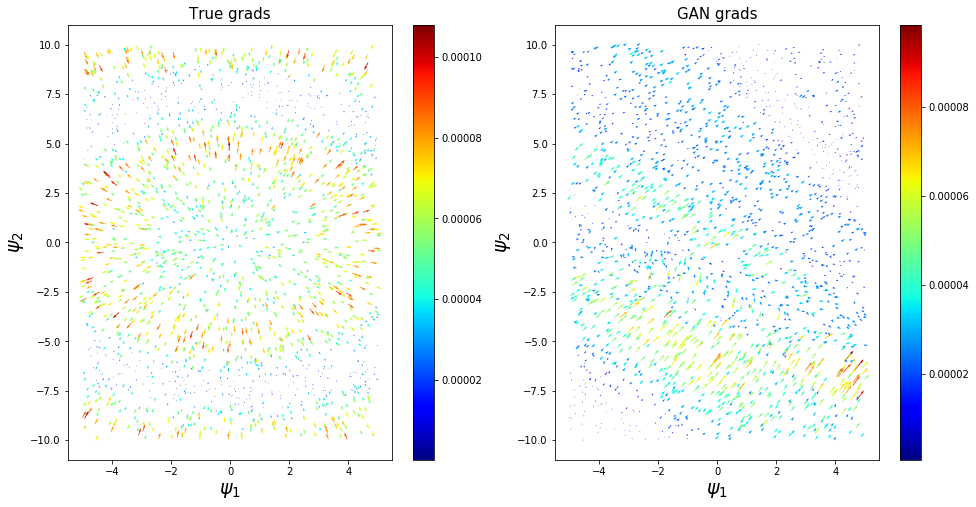

In [10]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.quiver(psi_grid[:, 0].cpu().detach().cpu().numpy(), 
           psi_grid[:,1].cpu().detach().cpu().numpy(), 
           -true_grads[:, 0], 
           -true_grads[:, 1],
           np.linalg.norm(true_grads,axis=1),
           cmap=my_cmap)
plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.title("True grads", fontsize=15)

plt.subplot(1,2,2)
plt.quiver(psi_grid[:, 0].cpu().detach().cpu().numpy(), 
           psi_grid[:,1].cpu().detach().cpu().numpy(), 
           -gan_grads[:, 0],
           -gan_grads[:, 1],
           np.linalg.norm(gan_grads,axis=1),
           cmap=my_cmap)
plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.title("GAN grads", fontsize=15)

In [9]:
import matplotlib.patches as patches

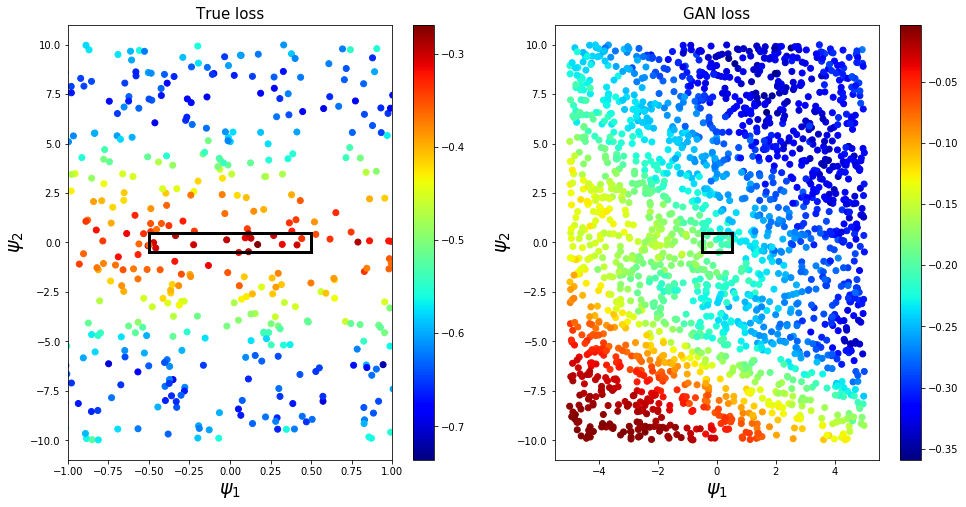

In [25]:
f = plt.figure(figsize=(16,8))

ax = plt.subplot(1,2,1)
plt.scatter(psi_grid[:, 0].cpu().detach().cpu().numpy(), 
           psi_grid[:,1].cpu().detach().cpu().numpy(), 
           c=true_loss.cpu().detach().numpy(),
           cmap=my_cmap)
plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.title("True loss", fontsize=15)
rect = patches.Rectangle((-0.5,-0.5),1,1,linewidth=3,edgecolor='black',facecolor='none')
ax.add_patch(rect)
plt.xlim(-1,1)

ax = plt.subplot(1,2,2)
plt.scatter(psi_grid[:, 0].cpu().detach().cpu().numpy(), 
           psi_grid[:,1].cpu().detach().cpu().numpy(), 
           c=gan_loss.cpu().detach().numpy(),
           cmap=my_cmap)
plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
plt.title("GAN loss", fontsize=15)
rect = patches.Rectangle((-0.5,-0.5),1,1,linewidth=3,edgecolor='black',facecolor='none')
ax.add_patch(rect)